## Sampling with Reformulated Negative Prompt 

As I mentioned in README.md, I reformulated CFG with negative prompt as below:

$$\tilde{\epsilon_\theta}(z_t, t, c) = \epsilon_\theta(z_t, t, \emptyset) + \lambda_P (\epsilon_\theta(z_t, t, c_P) - \epsilon_\theta(z_t, t, \emptyset)) + \lambda_N (\epsilon_\theta(z_t, t, \emptyset) - \epsilon_\theta(z_t, t, c_N))$$



In [9]:
import torch
from pipeline_stable_diffusion_negative_control import StableDiffusionPipelineNegativeControl
nc_pipe = StableDiffusionPipelineNegativeControl.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
nc_pipe = nc_pipe.to("cuda")

image = nc_pipe(
            prompt="A beautiful landscape with a clear blue sky",
            negative_prompt = "clouds, storm, fog",
            guidance_scale = 5.0,
            negative_guidance_scale = 7.5,
            generator = torch.Generator(device="cuda").manual_seed(42)
        ).images[0]


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]/root/anaconda3/envs/negative-prompt-reform/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 13.40it/s]
/root/anaconda3/envs/negative-prompt-reform/lib/python3.10/site-packages/diffusers/loaders/lora_pipeline.py:2251: FutureWarning: `LoraLoaderMixin` is deprecated and will be removed in version 1.0.0. LoraLoaderMixin is deprecated and this will be removed in a future version. Please use `StableDiffusionLoraLoaderMixin`, instead.
  deprecate("LoraLoaderMixin", "1.0.0", deprecation_message)
100%|██████████| 50/50 [00:03<00:00, 15.

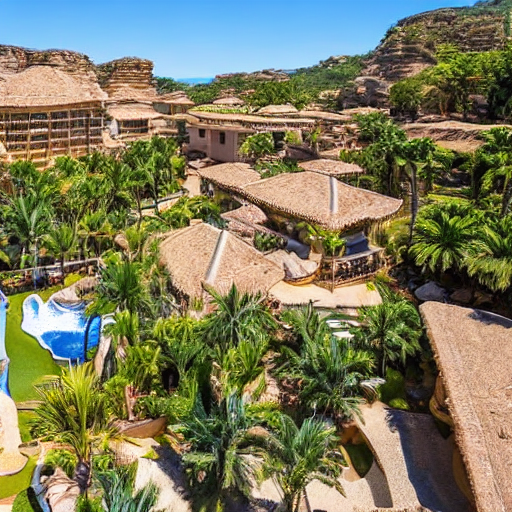

In [3]:
image

## Sampling with Reformulated Negative Prompt + CFG++

I implemented reformulation of negative prompt with CFG++ (Arxiv24, Chung et al.).

CFG++ the off-manifold issue inherent in CFG, thereby enabling effective utilization of small guidance scales (0 < $\lambda$ < 1). 

It uses the unconditional noise instead of the modulated noise in renosiing process, so it leads to smoother trajectory of generation because it performs interpolation when it modulates the noise while CFG performs extrapolation. 

Note that you can use CFG++ with DDIM Sampler only and you should set both guidance scales as [0.0, 1.0].
And, use DDIMScheduler with "ddim_scheduler.py" (modified version of diffusers) in this repostory. 

Please check the detail about CFG++ if you are interested:

[CFG++: Manifold-constrained Classifier Free Guidance for Diffusion Models](https://arxiv.org/abs/2406.08070v1)




In [10]:
import torch
from ddim_scheduler import DDIMScheduler
from pipeline_stable_diffusion_negative_control import StableDiffusionPipelineNegativeControl
pipe = StableDiffusionPipelineNegativeControl.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe = pipe.to("cuda")


# NOTE: If you wanna use CFG++, you should set DDIMScheduler as a scheduler and call pipeline with 'cfgpp=True'. 
pipe.scheduler = DDIMScheduler.from_config(
    pipe.scheduler.config, timestep_spacing="trailing", torch_dtype=torch.float16
)


image = pipe(
             prompt="A beautiful landscape with a clear blue sky",
            negative_prompt = "clouds, storm, fog",
            guidance_scale = 0.5,
            negative_guidance_scale = 1.0,
            generator = torch.Generator(device="cuda").manual_seed(42),
            cfgpp=True
        ).images[0]


100%|██████████| 50/50 [00:03<00:00, 15.61it/s]


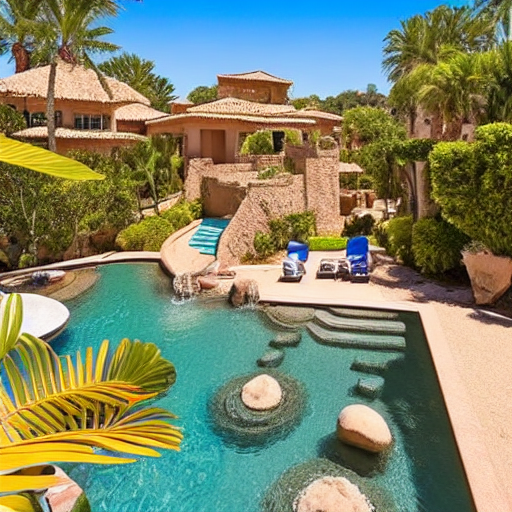

In [7]:
image

In [11]:
from pipeline_stable_diffusion_negative_control import StableDiffusionPipelineNegativeControl
pipe = StableDiffusionPipelineNegativeControl.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe = nc_pipe.to("cuda")
import os 

prompts = [
    "A snowy winter landscape with snow-covered trees and a cozy cabin",
    "A sunny beach with waves gently crashing on the shore",
    "A bustling city street at night with bright neon lights and people walking",
    "A beautiful landscape with a clear blue sky",
    "A portrait of a smiling person",
    "A vibrant cityscape at night",
    "A fantasy forest with magical creatures",
    "A detailed steampunk machine",
    "A serene beach with crystal clear water",
    "A futuristic city with flying cars",
    "A cute cartoon animal in a colorful environment",
    "A romantic sunset over a calm lake",
    "An abstract painting with vibrant colors",
]

negative_prompts = [
    "snow, snowflakes, snowy",
    "waves, ocean, water",
    "people, crowd, neon lights",
    "clouds, storm, fog",
    "frown, sad, angry",
    "daytime, sunlight, rural",
    "realistic, human, modern buildings",
    "modern technology, sleek design, minimalism",
    "waves, storm, cloudy sky",
    "historical buildings, horses, ancient architecture",
    "realistic, dull colors, serious expression",
    "storm, rain, sunrise",
    "realistic, monochrome, dull",
]

output_dir = "results/generated_images_reformed"
os.makedirs(output_dir, exist_ok=True)

for i, (prompt, negative_prompt) in enumerate(zip(prompts, negative_prompts)):
    for seed in range(5):
        for cfg_scale in [1.5, 3.0, 4.5, 6.0, 7.5, 9.0]:
            image = pipe(prompt=prompt, negative_prompt=negative_prompt, guidance_scale=7.5, negative_guidance_scale=cfg_scale, generator=torch.manual_seed(seed)).images[0]
            image_path = os.path.join(output_dir, f"nc{cfg_scale}_prompt_{i}_seed_{seed}.png")
            image.save(image_path)
            print(f"Saved seed {seed} for prompt {i} at {image_path}")


100%|██████████| 50/50 [00:03<00:00, 15.18it/s]


Saved seed 0 for prompt 0 at results/generated_images_reformed/nc1.5_prompt_0_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.26it/s]


Saved seed 0 for prompt 0 at results/generated_images_reformed/nc3.0_prompt_0_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.27it/s]


Saved seed 0 for prompt 0 at results/generated_images_reformed/nc4.5_prompt_0_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.28it/s]


Saved seed 0 for prompt 0 at results/generated_images_reformed/nc6.0_prompt_0_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.27it/s]


Saved seed 0 for prompt 0 at results/generated_images_reformed/nc7.5_prompt_0_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.28it/s]


Saved seed 0 for prompt 0 at results/generated_images_reformed/nc9.0_prompt_0_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.28it/s]


Saved seed 1 for prompt 0 at results/generated_images_reformed/nc1.5_prompt_0_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.28it/s]


Saved seed 1 for prompt 0 at results/generated_images_reformed/nc3.0_prompt_0_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.28it/s]


Saved seed 1 for prompt 0 at results/generated_images_reformed/nc4.5_prompt_0_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.27it/s]


Saved seed 1 for prompt 0 at results/generated_images_reformed/nc6.0_prompt_0_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.26it/s]


Saved seed 1 for prompt 0 at results/generated_images_reformed/nc7.5_prompt_0_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.27it/s]


Saved seed 1 for prompt 0 at results/generated_images_reformed/nc9.0_prompt_0_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.27it/s]


Saved seed 2 for prompt 0 at results/generated_images_reformed/nc1.5_prompt_0_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.27it/s]


Saved seed 2 for prompt 0 at results/generated_images_reformed/nc3.0_prompt_0_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.27it/s]


Saved seed 2 for prompt 0 at results/generated_images_reformed/nc4.5_prompt_0_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.26it/s]


Saved seed 2 for prompt 0 at results/generated_images_reformed/nc6.0_prompt_0_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.25it/s]


Saved seed 2 for prompt 0 at results/generated_images_reformed/nc7.5_prompt_0_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.26it/s]


Saved seed 2 for prompt 0 at results/generated_images_reformed/nc9.0_prompt_0_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.26it/s]


Saved seed 3 for prompt 0 at results/generated_images_reformed/nc1.5_prompt_0_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.25it/s]


Saved seed 3 for prompt 0 at results/generated_images_reformed/nc3.0_prompt_0_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.27it/s]


Saved seed 3 for prompt 0 at results/generated_images_reformed/nc4.5_prompt_0_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.26it/s]


Saved seed 3 for prompt 0 at results/generated_images_reformed/nc6.0_prompt_0_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.25it/s]


Saved seed 3 for prompt 0 at results/generated_images_reformed/nc7.5_prompt_0_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.26it/s]


Saved seed 3 for prompt 0 at results/generated_images_reformed/nc9.0_prompt_0_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.25it/s]


Saved seed 4 for prompt 0 at results/generated_images_reformed/nc1.5_prompt_0_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.26it/s]


Saved seed 4 for prompt 0 at results/generated_images_reformed/nc3.0_prompt_0_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.23it/s]


Saved seed 4 for prompt 0 at results/generated_images_reformed/nc4.5_prompt_0_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.24it/s]


Saved seed 4 for prompt 0 at results/generated_images_reformed/nc6.0_prompt_0_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.24it/s]


Saved seed 4 for prompt 0 at results/generated_images_reformed/nc7.5_prompt_0_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.24it/s]


Saved seed 4 for prompt 0 at results/generated_images_reformed/nc9.0_prompt_0_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.24it/s]


Saved seed 0 for prompt 1 at results/generated_images_reformed/nc1.5_prompt_1_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.24it/s]


Saved seed 0 for prompt 1 at results/generated_images_reformed/nc3.0_prompt_1_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.24it/s]


Saved seed 0 for prompt 1 at results/generated_images_reformed/nc4.5_prompt_1_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.23it/s]


Saved seed 0 for prompt 1 at results/generated_images_reformed/nc6.0_prompt_1_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.24it/s]


Saved seed 0 for prompt 1 at results/generated_images_reformed/nc7.5_prompt_1_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.24it/s]


Saved seed 0 for prompt 1 at results/generated_images_reformed/nc9.0_prompt_1_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.24it/s]


Saved seed 1 for prompt 1 at results/generated_images_reformed/nc1.5_prompt_1_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.24it/s]


Saved seed 1 for prompt 1 at results/generated_images_reformed/nc3.0_prompt_1_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.24it/s]


Saved seed 1 for prompt 1 at results/generated_images_reformed/nc4.5_prompt_1_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.24it/s]


Saved seed 1 for prompt 1 at results/generated_images_reformed/nc6.0_prompt_1_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.24it/s]


Saved seed 1 for prompt 1 at results/generated_images_reformed/nc7.5_prompt_1_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.25it/s]


Saved seed 1 for prompt 1 at results/generated_images_reformed/nc9.0_prompt_1_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.24it/s]


Saved seed 2 for prompt 1 at results/generated_images_reformed/nc1.5_prompt_1_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.24it/s]


Saved seed 2 for prompt 1 at results/generated_images_reformed/nc3.0_prompt_1_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.24it/s]


Saved seed 2 for prompt 1 at results/generated_images_reformed/nc4.5_prompt_1_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.24it/s]


Saved seed 2 for prompt 1 at results/generated_images_reformed/nc6.0_prompt_1_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.21it/s]


Saved seed 2 for prompt 1 at results/generated_images_reformed/nc7.5_prompt_1_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.24it/s]


Saved seed 2 for prompt 1 at results/generated_images_reformed/nc9.0_prompt_1_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.26it/s]


Saved seed 3 for prompt 1 at results/generated_images_reformed/nc1.5_prompt_1_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.25it/s]


Saved seed 3 for prompt 1 at results/generated_images_reformed/nc3.0_prompt_1_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.25it/s]


Saved seed 3 for prompt 1 at results/generated_images_reformed/nc4.5_prompt_1_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.25it/s]


Saved seed 3 for prompt 1 at results/generated_images_reformed/nc6.0_prompt_1_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.21it/s]


Saved seed 3 for prompt 1 at results/generated_images_reformed/nc7.5_prompt_1_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.13it/s]


Saved seed 3 for prompt 1 at results/generated_images_reformed/nc9.0_prompt_1_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.12it/s]


Saved seed 4 for prompt 1 at results/generated_images_reformed/nc1.5_prompt_1_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.12it/s]


Saved seed 4 for prompt 1 at results/generated_images_reformed/nc3.0_prompt_1_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.12it/s]


Saved seed 4 for prompt 1 at results/generated_images_reformed/nc4.5_prompt_1_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.12it/s]


Saved seed 4 for prompt 1 at results/generated_images_reformed/nc6.0_prompt_1_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.12it/s]


Saved seed 4 for prompt 1 at results/generated_images_reformed/nc7.5_prompt_1_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.11it/s]


Saved seed 4 for prompt 1 at results/generated_images_reformed/nc9.0_prompt_1_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.12it/s]


Saved seed 0 for prompt 2 at results/generated_images_reformed/nc1.5_prompt_2_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.11it/s]


Saved seed 0 for prompt 2 at results/generated_images_reformed/nc3.0_prompt_2_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.11it/s]


Saved seed 0 for prompt 2 at results/generated_images_reformed/nc4.5_prompt_2_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 0 for prompt 2 at results/generated_images_reformed/nc6.0_prompt_2_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.11it/s]


Saved seed 0 for prompt 2 at results/generated_images_reformed/nc7.5_prompt_2_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.11it/s]


Saved seed 0 for prompt 2 at results/generated_images_reformed/nc9.0_prompt_2_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.11it/s]


Saved seed 1 for prompt 2 at results/generated_images_reformed/nc1.5_prompt_2_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.11it/s]


Saved seed 1 for prompt 2 at results/generated_images_reformed/nc3.0_prompt_2_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.11it/s]


Saved seed 1 for prompt 2 at results/generated_images_reformed/nc4.5_prompt_2_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.11it/s]


Saved seed 1 for prompt 2 at results/generated_images_reformed/nc6.0_prompt_2_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 1 for prompt 2 at results/generated_images_reformed/nc7.5_prompt_2_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 1 for prompt 2 at results/generated_images_reformed/nc9.0_prompt_2_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 2 for prompt 2 at results/generated_images_reformed/nc1.5_prompt_2_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 2 for prompt 2 at results/generated_images_reformed/nc3.0_prompt_2_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.11it/s]


Saved seed 2 for prompt 2 at results/generated_images_reformed/nc4.5_prompt_2_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.11it/s]


Saved seed 2 for prompt 2 at results/generated_images_reformed/nc6.0_prompt_2_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.11it/s]


Saved seed 2 for prompt 2 at results/generated_images_reformed/nc7.5_prompt_2_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 2 for prompt 2 at results/generated_images_reformed/nc9.0_prompt_2_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.11it/s]


Saved seed 3 for prompt 2 at results/generated_images_reformed/nc1.5_prompt_2_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 3 for prompt 2 at results/generated_images_reformed/nc3.0_prompt_2_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 3 for prompt 2 at results/generated_images_reformed/nc4.5_prompt_2_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 3 for prompt 2 at results/generated_images_reformed/nc6.0_prompt_2_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 3 for prompt 2 at results/generated_images_reformed/nc7.5_prompt_2_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 3 for prompt 2 at results/generated_images_reformed/nc9.0_prompt_2_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 4 for prompt 2 at results/generated_images_reformed/nc1.5_prompt_2_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 4 for prompt 2 at results/generated_images_reformed/nc3.0_prompt_2_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 4 for prompt 2 at results/generated_images_reformed/nc4.5_prompt_2_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 4 for prompt 2 at results/generated_images_reformed/nc6.0_prompt_2_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 4 for prompt 2 at results/generated_images_reformed/nc7.5_prompt_2_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 4 for prompt 2 at results/generated_images_reformed/nc9.0_prompt_2_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 0 for prompt 3 at results/generated_images_reformed/nc1.5_prompt_3_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 0 for prompt 3 at results/generated_images_reformed/nc3.0_prompt_3_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 0 for prompt 3 at results/generated_images_reformed/nc4.5_prompt_3_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.11it/s]


Saved seed 0 for prompt 3 at results/generated_images_reformed/nc6.0_prompt_3_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.11it/s]


Saved seed 0 for prompt 3 at results/generated_images_reformed/nc7.5_prompt_3_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 0 for prompt 3 at results/generated_images_reformed/nc9.0_prompt_3_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 1 for prompt 3 at results/generated_images_reformed/nc1.5_prompt_3_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 1 for prompt 3 at results/generated_images_reformed/nc3.0_prompt_3_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.08it/s]


Saved seed 1 for prompt 3 at results/generated_images_reformed/nc4.5_prompt_3_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 1 for prompt 3 at results/generated_images_reformed/nc6.0_prompt_3_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.11it/s]


Saved seed 1 for prompt 3 at results/generated_images_reformed/nc7.5_prompt_3_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 1 for prompt 3 at results/generated_images_reformed/nc9.0_prompt_3_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 2 for prompt 3 at results/generated_images_reformed/nc1.5_prompt_3_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 2 for prompt 3 at results/generated_images_reformed/nc3.0_prompt_3_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.11it/s]


Saved seed 2 for prompt 3 at results/generated_images_reformed/nc4.5_prompt_3_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 2 for prompt 3 at results/generated_images_reformed/nc6.0_prompt_3_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 2 for prompt 3 at results/generated_images_reformed/nc7.5_prompt_3_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 2 for prompt 3 at results/generated_images_reformed/nc9.0_prompt_3_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 3 for prompt 3 at results/generated_images_reformed/nc1.5_prompt_3_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.11it/s]


Saved seed 3 for prompt 3 at results/generated_images_reformed/nc3.0_prompt_3_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 3 for prompt 3 at results/generated_images_reformed/nc4.5_prompt_3_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 3 for prompt 3 at results/generated_images_reformed/nc6.0_prompt_3_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 3 for prompt 3 at results/generated_images_reformed/nc7.5_prompt_3_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 3 for prompt 3 at results/generated_images_reformed/nc9.0_prompt_3_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 4 for prompt 3 at results/generated_images_reformed/nc1.5_prompt_3_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 4 for prompt 3 at results/generated_images_reformed/nc3.0_prompt_3_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 4 for prompt 3 at results/generated_images_reformed/nc4.5_prompt_3_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 4 for prompt 3 at results/generated_images_reformed/nc6.0_prompt_3_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 4 for prompt 3 at results/generated_images_reformed/nc7.5_prompt_3_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 4 for prompt 3 at results/generated_images_reformed/nc9.0_prompt_3_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 0 for prompt 4 at results/generated_images_reformed/nc1.5_prompt_4_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 0 for prompt 4 at results/generated_images_reformed/nc3.0_prompt_4_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 0 for prompt 4 at results/generated_images_reformed/nc4.5_prompt_4_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 0 for prompt 4 at results/generated_images_reformed/nc6.0_prompt_4_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 0 for prompt 4 at results/generated_images_reformed/nc7.5_prompt_4_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 0 for prompt 4 at results/generated_images_reformed/nc9.0_prompt_4_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 1 for prompt 4 at results/generated_images_reformed/nc1.5_prompt_4_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 1 for prompt 4 at results/generated_images_reformed/nc3.0_prompt_4_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 1 for prompt 4 at results/generated_images_reformed/nc4.5_prompt_4_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 1 for prompt 4 at results/generated_images_reformed/nc6.0_prompt_4_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 1 for prompt 4 at results/generated_images_reformed/nc7.5_prompt_4_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 1 for prompt 4 at results/generated_images_reformed/nc9.0_prompt_4_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 2 for prompt 4 at results/generated_images_reformed/nc1.5_prompt_4_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 2 for prompt 4 at results/generated_images_reformed/nc3.0_prompt_4_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 2 for prompt 4 at results/generated_images_reformed/nc4.5_prompt_4_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 2 for prompt 4 at results/generated_images_reformed/nc6.0_prompt_4_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 2 for prompt 4 at results/generated_images_reformed/nc7.5_prompt_4_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 2 for prompt 4 at results/generated_images_reformed/nc9.0_prompt_4_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 4 at results/generated_images_reformed/nc1.5_prompt_4_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 3 for prompt 4 at results/generated_images_reformed/nc3.0_prompt_4_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 3 for prompt 4 at results/generated_images_reformed/nc4.5_prompt_4_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 4 at results/generated_images_reformed/nc6.0_prompt_4_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 4 at results/generated_images_reformed/nc7.5_prompt_4_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 4 at results/generated_images_reformed/nc9.0_prompt_4_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 4 for prompt 4 at results/generated_images_reformed/nc1.5_prompt_4_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 4 for prompt 4 at results/generated_images_reformed/nc3.0_prompt_4_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 4 for prompt 4 at results/generated_images_reformed/nc4.5_prompt_4_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 4 for prompt 4 at results/generated_images_reformed/nc6.0_prompt_4_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 4 for prompt 4 at results/generated_images_reformed/nc7.5_prompt_4_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 4 for prompt 4 at results/generated_images_reformed/nc9.0_prompt_4_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.08it/s]


Saved seed 0 for prompt 5 at results/generated_images_reformed/nc1.5_prompt_5_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 0 for prompt 5 at results/generated_images_reformed/nc3.0_prompt_5_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 0 for prompt 5 at results/generated_images_reformed/nc4.5_prompt_5_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 0 for prompt 5 at results/generated_images_reformed/nc6.0_prompt_5_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 0 for prompt 5 at results/generated_images_reformed/nc7.5_prompt_5_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.11it/s]


Saved seed 0 for prompt 5 at results/generated_images_reformed/nc9.0_prompt_5_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 1 for prompt 5 at results/generated_images_reformed/nc1.5_prompt_5_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.11it/s]


Saved seed 1 for prompt 5 at results/generated_images_reformed/nc3.0_prompt_5_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 1 for prompt 5 at results/generated_images_reformed/nc4.5_prompt_5_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 1 for prompt 5 at results/generated_images_reformed/nc6.0_prompt_5_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 1 for prompt 5 at results/generated_images_reformed/nc7.5_prompt_5_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 1 for prompt 5 at results/generated_images_reformed/nc9.0_prompt_5_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.07it/s]


Saved seed 2 for prompt 5 at results/generated_images_reformed/nc1.5_prompt_5_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.08it/s]


Saved seed 2 for prompt 5 at results/generated_images_reformed/nc3.0_prompt_5_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 2 for prompt 5 at results/generated_images_reformed/nc4.5_prompt_5_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.08it/s]


Saved seed 2 for prompt 5 at results/generated_images_reformed/nc6.0_prompt_5_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 2 for prompt 5 at results/generated_images_reformed/nc7.5_prompt_5_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 2 for prompt 5 at results/generated_images_reformed/nc9.0_prompt_5_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.08it/s]


Saved seed 3 for prompt 5 at results/generated_images_reformed/nc1.5_prompt_5_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 3 for prompt 5 at results/generated_images_reformed/nc3.0_prompt_5_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 5 at results/generated_images_reformed/nc4.5_prompt_5_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 5 at results/generated_images_reformed/nc6.0_prompt_5_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 5 at results/generated_images_reformed/nc7.5_prompt_5_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 3 for prompt 5 at results/generated_images_reformed/nc9.0_prompt_5_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 4 for prompt 5 at results/generated_images_reformed/nc1.5_prompt_5_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 4 for prompt 5 at results/generated_images_reformed/nc3.0_prompt_5_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 4 for prompt 5 at results/generated_images_reformed/nc4.5_prompt_5_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 4 for prompt 5 at results/generated_images_reformed/nc6.0_prompt_5_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 4 for prompt 5 at results/generated_images_reformed/nc7.5_prompt_5_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 4 for prompt 5 at results/generated_images_reformed/nc9.0_prompt_5_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 0 for prompt 6 at results/generated_images_reformed/nc1.5_prompt_6_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 0 for prompt 6 at results/generated_images_reformed/nc3.0_prompt_6_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 0 for prompt 6 at results/generated_images_reformed/nc4.5_prompt_6_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 0 for prompt 6 at results/generated_images_reformed/nc6.0_prompt_6_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 0 for prompt 6 at results/generated_images_reformed/nc7.5_prompt_6_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 0 for prompt 6 at results/generated_images_reformed/nc9.0_prompt_6_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 1 for prompt 6 at results/generated_images_reformed/nc1.5_prompt_6_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 1 for prompt 6 at results/generated_images_reformed/nc3.0_prompt_6_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 1 for prompt 6 at results/generated_images_reformed/nc4.5_prompt_6_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.08it/s]


Saved seed 1 for prompt 6 at results/generated_images_reformed/nc6.0_prompt_6_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 1 for prompt 6 at results/generated_images_reformed/nc7.5_prompt_6_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 1 for prompt 6 at results/generated_images_reformed/nc9.0_prompt_6_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 2 for prompt 6 at results/generated_images_reformed/nc1.5_prompt_6_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 2 for prompt 6 at results/generated_images_reformed/nc3.0_prompt_6_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 2 for prompt 6 at results/generated_images_reformed/nc4.5_prompt_6_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 2 for prompt 6 at results/generated_images_reformed/nc6.0_prompt_6_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.11it/s]


Saved seed 2 for prompt 6 at results/generated_images_reformed/nc7.5_prompt_6_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 2 for prompt 6 at results/generated_images_reformed/nc9.0_prompt_6_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 3 for prompt 6 at results/generated_images_reformed/nc1.5_prompt_6_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 3 for prompt 6 at results/generated_images_reformed/nc3.0_prompt_6_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 3 for prompt 6 at results/generated_images_reformed/nc4.5_prompt_6_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 3 for prompt 6 at results/generated_images_reformed/nc6.0_prompt_6_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 3 for prompt 6 at results/generated_images_reformed/nc7.5_prompt_6_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 6 at results/generated_images_reformed/nc9.0_prompt_6_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 4 for prompt 6 at results/generated_images_reformed/nc1.5_prompt_6_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 4 for prompt 6 at results/generated_images_reformed/nc3.0_prompt_6_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 4 for prompt 6 at results/generated_images_reformed/nc4.5_prompt_6_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 4 for prompt 6 at results/generated_images_reformed/nc6.0_prompt_6_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 4 for prompt 6 at results/generated_images_reformed/nc7.5_prompt_6_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 4 for prompt 6 at results/generated_images_reformed/nc9.0_prompt_6_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 0 for prompt 7 at results/generated_images_reformed/nc1.5_prompt_7_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 0 for prompt 7 at results/generated_images_reformed/nc3.0_prompt_7_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 0 for prompt 7 at results/generated_images_reformed/nc4.5_prompt_7_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 0 for prompt 7 at results/generated_images_reformed/nc6.0_prompt_7_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 0 for prompt 7 at results/generated_images_reformed/nc7.5_prompt_7_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 0 for prompt 7 at results/generated_images_reformed/nc9.0_prompt_7_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 1 for prompt 7 at results/generated_images_reformed/nc1.5_prompt_7_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 1 for prompt 7 at results/generated_images_reformed/nc3.0_prompt_7_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 1 for prompt 7 at results/generated_images_reformed/nc4.5_prompt_7_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 1 for prompt 7 at results/generated_images_reformed/nc6.0_prompt_7_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 1 for prompt 7 at results/generated_images_reformed/nc7.5_prompt_7_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 1 for prompt 7 at results/generated_images_reformed/nc9.0_prompt_7_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 2 for prompt 7 at results/generated_images_reformed/nc1.5_prompt_7_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 2 for prompt 7 at results/generated_images_reformed/nc3.0_prompt_7_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 2 for prompt 7 at results/generated_images_reformed/nc4.5_prompt_7_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 2 for prompt 7 at results/generated_images_reformed/nc6.0_prompt_7_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 2 for prompt 7 at results/generated_images_reformed/nc7.5_prompt_7_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 2 for prompt 7 at results/generated_images_reformed/nc9.0_prompt_7_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 7 at results/generated_images_reformed/nc1.5_prompt_7_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 7 at results/generated_images_reformed/nc3.0_prompt_7_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 3 for prompt 7 at results/generated_images_reformed/nc4.5_prompt_7_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 7 at results/generated_images_reformed/nc6.0_prompt_7_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 7 at results/generated_images_reformed/nc7.5_prompt_7_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 7 at results/generated_images_reformed/nc9.0_prompt_7_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 4 for prompt 7 at results/generated_images_reformed/nc1.5_prompt_7_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 4 for prompt 7 at results/generated_images_reformed/nc3.0_prompt_7_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 4 for prompt 7 at results/generated_images_reformed/nc4.5_prompt_7_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 4 for prompt 7 at results/generated_images_reformed/nc6.0_prompt_7_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.08it/s]


Saved seed 4 for prompt 7 at results/generated_images_reformed/nc7.5_prompt_7_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 4 for prompt 7 at results/generated_images_reformed/nc9.0_prompt_7_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 0 for prompt 8 at results/generated_images_reformed/nc1.5_prompt_8_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 0 for prompt 8 at results/generated_images_reformed/nc3.0_prompt_8_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 0 for prompt 8 at results/generated_images_reformed/nc4.5_prompt_8_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 0 for prompt 8 at results/generated_images_reformed/nc6.0_prompt_8_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 0 for prompt 8 at results/generated_images_reformed/nc7.5_prompt_8_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 0 for prompt 8 at results/generated_images_reformed/nc9.0_prompt_8_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 1 for prompt 8 at results/generated_images_reformed/nc1.5_prompt_8_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 1 for prompt 8 at results/generated_images_reformed/nc3.0_prompt_8_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 1 for prompt 8 at results/generated_images_reformed/nc4.5_prompt_8_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 1 for prompt 8 at results/generated_images_reformed/nc6.0_prompt_8_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 1 for prompt 8 at results/generated_images_reformed/nc7.5_prompt_8_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 1 for prompt 8 at results/generated_images_reformed/nc9.0_prompt_8_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 2 for prompt 8 at results/generated_images_reformed/nc1.5_prompt_8_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 2 for prompt 8 at results/generated_images_reformed/nc3.0_prompt_8_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.08it/s]


Saved seed 2 for prompt 8 at results/generated_images_reformed/nc4.5_prompt_8_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 2 for prompt 8 at results/generated_images_reformed/nc6.0_prompt_8_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 2 for prompt 8 at results/generated_images_reformed/nc7.5_prompt_8_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 2 for prompt 8 at results/generated_images_reformed/nc9.0_prompt_8_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 3 for prompt 8 at results/generated_images_reformed/nc1.5_prompt_8_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 8 at results/generated_images_reformed/nc3.0_prompt_8_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 8 at results/generated_images_reformed/nc4.5_prompt_8_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 3 for prompt 8 at results/generated_images_reformed/nc6.0_prompt_8_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 8 at results/generated_images_reformed/nc7.5_prompt_8_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 8 at results/generated_images_reformed/nc9.0_prompt_8_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 4 for prompt 8 at results/generated_images_reformed/nc1.5_prompt_8_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 4 for prompt 8 at results/generated_images_reformed/nc3.0_prompt_8_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.08it/s]


Saved seed 4 for prompt 8 at results/generated_images_reformed/nc4.5_prompt_8_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.08it/s]


Saved seed 4 for prompt 8 at results/generated_images_reformed/nc6.0_prompt_8_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 4 for prompt 8 at results/generated_images_reformed/nc7.5_prompt_8_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 4 for prompt 8 at results/generated_images_reformed/nc9.0_prompt_8_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 0 for prompt 9 at results/generated_images_reformed/nc1.5_prompt_9_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 0 for prompt 9 at results/generated_images_reformed/nc3.0_prompt_9_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 0 for prompt 9 at results/generated_images_reformed/nc4.5_prompt_9_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.08it/s]


Saved seed 0 for prompt 9 at results/generated_images_reformed/nc6.0_prompt_9_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 0 for prompt 9 at results/generated_images_reformed/nc7.5_prompt_9_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 0 for prompt 9 at results/generated_images_reformed/nc9.0_prompt_9_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 1 for prompt 9 at results/generated_images_reformed/nc1.5_prompt_9_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 1 for prompt 9 at results/generated_images_reformed/nc3.0_prompt_9_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 1 for prompt 9 at results/generated_images_reformed/nc4.5_prompt_9_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 1 for prompt 9 at results/generated_images_reformed/nc6.0_prompt_9_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 1 for prompt 9 at results/generated_images_reformed/nc7.5_prompt_9_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 1 for prompt 9 at results/generated_images_reformed/nc9.0_prompt_9_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 2 for prompt 9 at results/generated_images_reformed/nc1.5_prompt_9_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.08it/s]


Saved seed 2 for prompt 9 at results/generated_images_reformed/nc3.0_prompt_9_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 2 for prompt 9 at results/generated_images_reformed/nc4.5_prompt_9_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.08it/s]


Saved seed 2 for prompt 9 at results/generated_images_reformed/nc6.0_prompt_9_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 2 for prompt 9 at results/generated_images_reformed/nc7.5_prompt_9_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 2 for prompt 9 at results/generated_images_reformed/nc9.0_prompt_9_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 9 at results/generated_images_reformed/nc1.5_prompt_9_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 9 at results/generated_images_reformed/nc3.0_prompt_9_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 9 at results/generated_images_reformed/nc4.5_prompt_9_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 9 at results/generated_images_reformed/nc6.0_prompt_9_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 3 for prompt 9 at results/generated_images_reformed/nc7.5_prompt_9_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 3 for prompt 9 at results/generated_images_reformed/nc9.0_prompt_9_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 4 for prompt 9 at results/generated_images_reformed/nc1.5_prompt_9_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 4 for prompt 9 at results/generated_images_reformed/nc3.0_prompt_9_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 4 for prompt 9 at results/generated_images_reformed/nc4.5_prompt_9_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 4 for prompt 9 at results/generated_images_reformed/nc6.0_prompt_9_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 4 for prompt 9 at results/generated_images_reformed/nc7.5_prompt_9_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 4 for prompt 9 at results/generated_images_reformed/nc9.0_prompt_9_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 0 for prompt 10 at results/generated_images_reformed/nc1.5_prompt_10_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 0 for prompt 10 at results/generated_images_reformed/nc3.0_prompt_10_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 0 for prompt 10 at results/generated_images_reformed/nc4.5_prompt_10_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 0 for prompt 10 at results/generated_images_reformed/nc6.0_prompt_10_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 0 for prompt 10 at results/generated_images_reformed/nc7.5_prompt_10_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 0 for prompt 10 at results/generated_images_reformed/nc9.0_prompt_10_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 1 for prompt 10 at results/generated_images_reformed/nc1.5_prompt_10_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 1 for prompt 10 at results/generated_images_reformed/nc3.0_prompt_10_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.08it/s]


Saved seed 1 for prompt 10 at results/generated_images_reformed/nc4.5_prompt_10_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 1 for prompt 10 at results/generated_images_reformed/nc6.0_prompt_10_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.08it/s]


Saved seed 1 for prompt 10 at results/generated_images_reformed/nc7.5_prompt_10_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 1 for prompt 10 at results/generated_images_reformed/nc9.0_prompt_10_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 2 for prompt 10 at results/generated_images_reformed/nc1.5_prompt_10_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 2 for prompt 10 at results/generated_images_reformed/nc3.0_prompt_10_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 2 for prompt 10 at results/generated_images_reformed/nc4.5_prompt_10_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 2 for prompt 10 at results/generated_images_reformed/nc6.0_prompt_10_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 2 for prompt 10 at results/generated_images_reformed/nc7.5_prompt_10_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 2 for prompt 10 at results/generated_images_reformed/nc9.0_prompt_10_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 10 at results/generated_images_reformed/nc1.5_prompt_10_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 3 for prompt 10 at results/generated_images_reformed/nc3.0_prompt_10_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 10 at results/generated_images_reformed/nc4.5_prompt_10_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 10 at results/generated_images_reformed/nc6.0_prompt_10_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 10 at results/generated_images_reformed/nc7.5_prompt_10_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 10 at results/generated_images_reformed/nc9.0_prompt_10_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 4 for prompt 10 at results/generated_images_reformed/nc1.5_prompt_10_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 4 for prompt 10 at results/generated_images_reformed/nc3.0_prompt_10_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 4 for prompt 10 at results/generated_images_reformed/nc4.5_prompt_10_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 4 for prompt 10 at results/generated_images_reformed/nc6.0_prompt_10_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 4 for prompt 10 at results/generated_images_reformed/nc7.5_prompt_10_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 4 for prompt 10 at results/generated_images_reformed/nc9.0_prompt_10_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 0 for prompt 11 at results/generated_images_reformed/nc1.5_prompt_11_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 0 for prompt 11 at results/generated_images_reformed/nc3.0_prompt_11_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 0 for prompt 11 at results/generated_images_reformed/nc4.5_prompt_11_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 0 for prompt 11 at results/generated_images_reformed/nc6.0_prompt_11_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 0 for prompt 11 at results/generated_images_reformed/nc7.5_prompt_11_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 0 for prompt 11 at results/generated_images_reformed/nc9.0_prompt_11_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 1 for prompt 11 at results/generated_images_reformed/nc1.5_prompt_11_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.08it/s]


Saved seed 1 for prompt 11 at results/generated_images_reformed/nc3.0_prompt_11_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 1 for prompt 11 at results/generated_images_reformed/nc4.5_prompt_11_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 1 for prompt 11 at results/generated_images_reformed/nc6.0_prompt_11_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 1 for prompt 11 at results/generated_images_reformed/nc7.5_prompt_11_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 1 for prompt 11 at results/generated_images_reformed/nc9.0_prompt_11_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 2 for prompt 11 at results/generated_images_reformed/nc1.5_prompt_11_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.08it/s]


Saved seed 2 for prompt 11 at results/generated_images_reformed/nc3.0_prompt_11_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 2 for prompt 11 at results/generated_images_reformed/nc4.5_prompt_11_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 2 for prompt 11 at results/generated_images_reformed/nc6.0_prompt_11_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 2 for prompt 11 at results/generated_images_reformed/nc7.5_prompt_11_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 2 for prompt 11 at results/generated_images_reformed/nc9.0_prompt_11_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 11 at results/generated_images_reformed/nc1.5_prompt_11_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 11 at results/generated_images_reformed/nc3.0_prompt_11_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 11 at results/generated_images_reformed/nc4.5_prompt_11_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 3 for prompt 11 at results/generated_images_reformed/nc6.0_prompt_11_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 11 at results/generated_images_reformed/nc7.5_prompt_11_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 11 at results/generated_images_reformed/nc9.0_prompt_11_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 4 for prompt 11 at results/generated_images_reformed/nc1.5_prompt_11_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 4 for prompt 11 at results/generated_images_reformed/nc3.0_prompt_11_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 4 for prompt 11 at results/generated_images_reformed/nc4.5_prompt_11_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 4 for prompt 11 at results/generated_images_reformed/nc6.0_prompt_11_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 4 for prompt 11 at results/generated_images_reformed/nc7.5_prompt_11_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 4 for prompt 11 at results/generated_images_reformed/nc9.0_prompt_11_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 0 for prompt 12 at results/generated_images_reformed/nc1.5_prompt_12_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 0 for prompt 12 at results/generated_images_reformed/nc3.0_prompt_12_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 0 for prompt 12 at results/generated_images_reformed/nc4.5_prompt_12_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 0 for prompt 12 at results/generated_images_reformed/nc6.0_prompt_12_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 0 for prompt 12 at results/generated_images_reformed/nc7.5_prompt_12_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 0 for prompt 12 at results/generated_images_reformed/nc9.0_prompt_12_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 1 for prompt 12 at results/generated_images_reformed/nc1.5_prompt_12_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 1 for prompt 12 at results/generated_images_reformed/nc3.0_prompt_12_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 1 for prompt 12 at results/generated_images_reformed/nc4.5_prompt_12_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 1 for prompt 12 at results/generated_images_reformed/nc6.0_prompt_12_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 1 for prompt 12 at results/generated_images_reformed/nc7.5_prompt_12_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved seed 1 for prompt 12 at results/generated_images_reformed/nc9.0_prompt_12_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.08it/s]


Saved seed 2 for prompt 12 at results/generated_images_reformed/nc1.5_prompt_12_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 2 for prompt 12 at results/generated_images_reformed/nc3.0_prompt_12_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 2 for prompt 12 at results/generated_images_reformed/nc4.5_prompt_12_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.08it/s]


Saved seed 2 for prompt 12 at results/generated_images_reformed/nc6.0_prompt_12_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 2 for prompt 12 at results/generated_images_reformed/nc7.5_prompt_12_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 2 for prompt 12 at results/generated_images_reformed/nc9.0_prompt_12_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.08it/s]


Saved seed 3 for prompt 12 at results/generated_images_reformed/nc1.5_prompt_12_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 12 at results/generated_images_reformed/nc3.0_prompt_12_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 12 at results/generated_images_reformed/nc4.5_prompt_12_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 12 at results/generated_images_reformed/nc6.0_prompt_12_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 12 at results/generated_images_reformed/nc7.5_prompt_12_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 3 for prompt 12 at results/generated_images_reformed/nc9.0_prompt_12_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 4 for prompt 12 at results/generated_images_reformed/nc1.5_prompt_12_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 4 for prompt 12 at results/generated_images_reformed/nc3.0_prompt_12_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 4 for prompt 12 at results/generated_images_reformed/nc4.5_prompt_12_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 4 for prompt 12 at results/generated_images_reformed/nc6.0_prompt_12_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.08it/s]


Saved seed 4 for prompt 12 at results/generated_images_reformed/nc7.5_prompt_12_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved seed 4 for prompt 12 at results/generated_images_reformed/nc9.0_prompt_12_seed_4.png


In [16]:
from pipeline_stable_diffusion_negative_control import StableDiffusionPipelineNegativeControl
import os 


pipe = StableDiffusionPipelineNegativeControl.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe = pipe.to("cuda")
pipe.scheduler = DDIMScheduler.from_config(
    pipe.scheduler.config, timestep_spacing="trailing", torch_dtype=torch.float16
)

prompts = [
    "A snowy winter landscape with snow-covered trees and a cozy cabin",
    "A sunny beach with waves gently crashing on the shore",
    "A bustling city street at night with bright neon lights and people walking",
    "A beautiful landscape with a clear blue sky",
    "A portrait of a smiling person",
    "A vibrant cityscape at night",
    "A fantasy forest with magical creatures",
    "A detailed steampunk machine",
    "A serene beach with crystal clear water",
    "A futuristic city with flying cars",
    "A cute cartoon animal in a colorful environment",
    "A romantic sunset over a calm lake",
    "An abstract painting with vibrant colors",
]

negative_prompts = [
    "snow, snowflakes, snowy",
    "waves, ocean, water",
    "people, crowd, neon lights",
    "clouds, storm, fog",
    "frown, sad, angry",
    "daytime, sunlight, rural",
    "realistic, human, modern buildings",
    "modern technology, sleek design, minimalism",
    "waves, storm, cloudy sky",
    "historical buildings, horses, ancient architecture",
    "realistic, dull colors, serious expression",
    "storm, rain, sunrise",
    "realistic, monochrome, dull",
]

output_dir = "results/generated_images_reformed_CFG++"
os.makedirs(output_dir, exist_ok=True)

for i, (prompt, negative_prompt) in enumerate(zip(prompts, negative_prompts)):
    for seed in range(5):
        for cfg_scale in [0.2, 0.4, 0.6, 0.8, 1.0]:
            image = pipe(prompt=prompt, 
                         negative_prompt=negative_prompt, 
                         guidance_scale=0.6, 
                         negative_guidance_scale=cfg_scale, 
                         generator=torch.manual_seed(seed),
                         cfgpp=True
                         ).images[0]
            image_path = os.path.join(output_dir, f"nc{cfg_scale}_prompt_{i}_seed_{seed}.png")
            image.save(image_path)
            print(f"Saved seed {seed} for prompt {i} at {image_path}")


100%|██████████| 50/50 [00:03<00:00, 15.54it/s]


Saved seed 0 for prompt 0 at results/generated_images_reformed_CFG++/nc0.2_prompt_0_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.55it/s]


Saved seed 0 for prompt 0 at results/generated_images_reformed_CFG++/nc0.4_prompt_0_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.53it/s]


Saved seed 0 for prompt 0 at results/generated_images_reformed_CFG++/nc0.6_prompt_0_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.54it/s]


Saved seed 0 for prompt 0 at results/generated_images_reformed_CFG++/nc0.8_prompt_0_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.54it/s]


Saved seed 0 for prompt 0 at results/generated_images_reformed_CFG++/nc1.0_prompt_0_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.54it/s]


Saved seed 1 for prompt 0 at results/generated_images_reformed_CFG++/nc0.2_prompt_0_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.54it/s]


Saved seed 1 for prompt 0 at results/generated_images_reformed_CFG++/nc0.4_prompt_0_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.53it/s]


Saved seed 1 for prompt 0 at results/generated_images_reformed_CFG++/nc0.6_prompt_0_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.53it/s]


Saved seed 1 for prompt 0 at results/generated_images_reformed_CFG++/nc0.8_prompt_0_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.52it/s]


Saved seed 1 for prompt 0 at results/generated_images_reformed_CFG++/nc1.0_prompt_0_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.53it/s]


Saved seed 2 for prompt 0 at results/generated_images_reformed_CFG++/nc0.2_prompt_0_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.53it/s]


Saved seed 2 for prompt 0 at results/generated_images_reformed_CFG++/nc0.4_prompt_0_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.52it/s]


Saved seed 2 for prompt 0 at results/generated_images_reformed_CFG++/nc0.6_prompt_0_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.52it/s]


Saved seed 2 for prompt 0 at results/generated_images_reformed_CFG++/nc0.8_prompt_0_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.54it/s]


Saved seed 2 for prompt 0 at results/generated_images_reformed_CFG++/nc1.0_prompt_0_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.53it/s]


Saved seed 3 for prompt 0 at results/generated_images_reformed_CFG++/nc0.2_prompt_0_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.52it/s]


Saved seed 3 for prompt 0 at results/generated_images_reformed_CFG++/nc0.4_prompt_0_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.52it/s]


Saved seed 3 for prompt 0 at results/generated_images_reformed_CFG++/nc0.6_prompt_0_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.50it/s]


Saved seed 3 for prompt 0 at results/generated_images_reformed_CFG++/nc0.8_prompt_0_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.50it/s]


Saved seed 3 for prompt 0 at results/generated_images_reformed_CFG++/nc1.0_prompt_0_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.48it/s]


Saved seed 4 for prompt 0 at results/generated_images_reformed_CFG++/nc0.2_prompt_0_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.52it/s]


Saved seed 4 for prompt 0 at results/generated_images_reformed_CFG++/nc0.4_prompt_0_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.53it/s]


Saved seed 4 for prompt 0 at results/generated_images_reformed_CFG++/nc0.6_prompt_0_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.52it/s]


Saved seed 4 for prompt 0 at results/generated_images_reformed_CFG++/nc0.8_prompt_0_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.52it/s]


Saved seed 4 for prompt 0 at results/generated_images_reformed_CFG++/nc1.0_prompt_0_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.51it/s]


Saved seed 0 for prompt 1 at results/generated_images_reformed_CFG++/nc0.2_prompt_1_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.45it/s]


Saved seed 0 for prompt 1 at results/generated_images_reformed_CFG++/nc0.4_prompt_1_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.46it/s]


Saved seed 0 for prompt 1 at results/generated_images_reformed_CFG++/nc0.6_prompt_1_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.47it/s]


Saved seed 0 for prompt 1 at results/generated_images_reformed_CFG++/nc0.8_prompt_1_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.46it/s]


Saved seed 0 for prompt 1 at results/generated_images_reformed_CFG++/nc1.0_prompt_1_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.47it/s]


Saved seed 1 for prompt 1 at results/generated_images_reformed_CFG++/nc0.2_prompt_1_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.47it/s]


Saved seed 1 for prompt 1 at results/generated_images_reformed_CFG++/nc0.4_prompt_1_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.46it/s]


Saved seed 1 for prompt 1 at results/generated_images_reformed_CFG++/nc0.6_prompt_1_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.46it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Saved seed 1 for prompt 1 at results/generated_images_reformed_CFG++/nc0.8_prompt_1_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.47it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Saved seed 1 for prompt 1 at results/generated_images_reformed_CFG++/nc1.0_prompt_1_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.46it/s]


Saved seed 2 for prompt 1 at results/generated_images_reformed_CFG++/nc0.2_prompt_1_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.47it/s]


Saved seed 2 for prompt 1 at results/generated_images_reformed_CFG++/nc0.4_prompt_1_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.46it/s]


Saved seed 2 for prompt 1 at results/generated_images_reformed_CFG++/nc0.6_prompt_1_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.45it/s]


Saved seed 2 for prompt 1 at results/generated_images_reformed_CFG++/nc0.8_prompt_1_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.47it/s]


Saved seed 2 for prompt 1 at results/generated_images_reformed_CFG++/nc1.0_prompt_1_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.46it/s]


Saved seed 3 for prompt 1 at results/generated_images_reformed_CFG++/nc0.2_prompt_1_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.46it/s]


Saved seed 3 for prompt 1 at results/generated_images_reformed_CFG++/nc0.4_prompt_1_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.46it/s]


Saved seed 3 for prompt 1 at results/generated_images_reformed_CFG++/nc0.6_prompt_1_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.45it/s]


Saved seed 3 for prompt 1 at results/generated_images_reformed_CFG++/nc0.8_prompt_1_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.46it/s]


Saved seed 3 for prompt 1 at results/generated_images_reformed_CFG++/nc1.0_prompt_1_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.46it/s]


Saved seed 4 for prompt 1 at results/generated_images_reformed_CFG++/nc0.2_prompt_1_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.46it/s]


Saved seed 4 for prompt 1 at results/generated_images_reformed_CFG++/nc0.4_prompt_1_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.46it/s]


Saved seed 4 for prompt 1 at results/generated_images_reformed_CFG++/nc0.6_prompt_1_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.45it/s]


Saved seed 4 for prompt 1 at results/generated_images_reformed_CFG++/nc0.8_prompt_1_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 4 for prompt 1 at results/generated_images_reformed_CFG++/nc1.0_prompt_1_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


Saved seed 0 for prompt 2 at results/generated_images_reformed_CFG++/nc0.2_prompt_2_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 0 for prompt 2 at results/generated_images_reformed_CFG++/nc0.4_prompt_2_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


Saved seed 0 for prompt 2 at results/generated_images_reformed_CFG++/nc0.6_prompt_2_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.46it/s]


Saved seed 0 for prompt 2 at results/generated_images_reformed_CFG++/nc0.8_prompt_2_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.45it/s]


Saved seed 0 for prompt 2 at results/generated_images_reformed_CFG++/nc1.0_prompt_2_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.45it/s]


Saved seed 1 for prompt 2 at results/generated_images_reformed_CFG++/nc0.2_prompt_2_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


Saved seed 1 for prompt 2 at results/generated_images_reformed_CFG++/nc0.4_prompt_2_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.45it/s]


Saved seed 1 for prompt 2 at results/generated_images_reformed_CFG++/nc0.6_prompt_2_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.45it/s]


Saved seed 1 for prompt 2 at results/generated_images_reformed_CFG++/nc0.8_prompt_2_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.46it/s]


Saved seed 1 for prompt 2 at results/generated_images_reformed_CFG++/nc1.0_prompt_2_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


Saved seed 2 for prompt 2 at results/generated_images_reformed_CFG++/nc0.2_prompt_2_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 2 for prompt 2 at results/generated_images_reformed_CFG++/nc0.4_prompt_2_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 2 for prompt 2 at results/generated_images_reformed_CFG++/nc0.6_prompt_2_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 2 for prompt 2 at results/generated_images_reformed_CFG++/nc0.8_prompt_2_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 2 for prompt 2 at results/generated_images_reformed_CFG++/nc1.0_prompt_2_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


Saved seed 3 for prompt 2 at results/generated_images_reformed_CFG++/nc0.2_prompt_2_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


Saved seed 3 for prompt 2 at results/generated_images_reformed_CFG++/nc0.4_prompt_2_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 3 for prompt 2 at results/generated_images_reformed_CFG++/nc0.6_prompt_2_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


Saved seed 3 for prompt 2 at results/generated_images_reformed_CFG++/nc0.8_prompt_2_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 3 for prompt 2 at results/generated_images_reformed_CFG++/nc1.0_prompt_2_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 4 for prompt 2 at results/generated_images_reformed_CFG++/nc0.2_prompt_2_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 4 for prompt 2 at results/generated_images_reformed_CFG++/nc0.4_prompt_2_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 4 for prompt 2 at results/generated_images_reformed_CFG++/nc0.6_prompt_2_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 4 for prompt 2 at results/generated_images_reformed_CFG++/nc0.8_prompt_2_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 4 for prompt 2 at results/generated_images_reformed_CFG++/nc1.0_prompt_2_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 0 for prompt 3 at results/generated_images_reformed_CFG++/nc0.2_prompt_3_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 0 for prompt 3 at results/generated_images_reformed_CFG++/nc0.4_prompt_3_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 0 for prompt 3 at results/generated_images_reformed_CFG++/nc0.6_prompt_3_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


Saved seed 0 for prompt 3 at results/generated_images_reformed_CFG++/nc0.8_prompt_3_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 0 for prompt 3 at results/generated_images_reformed_CFG++/nc1.0_prompt_3_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.45it/s]


Saved seed 1 for prompt 3 at results/generated_images_reformed_CFG++/nc0.2_prompt_3_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.45it/s]


Saved seed 1 for prompt 3 at results/generated_images_reformed_CFG++/nc0.4_prompt_3_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


Saved seed 1 for prompt 3 at results/generated_images_reformed_CFG++/nc0.6_prompt_3_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.45it/s]


Saved seed 1 for prompt 3 at results/generated_images_reformed_CFG++/nc0.8_prompt_3_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 1 for prompt 3 at results/generated_images_reformed_CFG++/nc1.0_prompt_3_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


Saved seed 2 for prompt 3 at results/generated_images_reformed_CFG++/nc0.2_prompt_3_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


Saved seed 2 for prompt 3 at results/generated_images_reformed_CFG++/nc0.4_prompt_3_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


Saved seed 2 for prompt 3 at results/generated_images_reformed_CFG++/nc0.6_prompt_3_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 2 for prompt 3 at results/generated_images_reformed_CFG++/nc0.8_prompt_3_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 2 for prompt 3 at results/generated_images_reformed_CFG++/nc1.0_prompt_3_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 3 for prompt 3 at results/generated_images_reformed_CFG++/nc0.2_prompt_3_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 3 for prompt 3 at results/generated_images_reformed_CFG++/nc0.4_prompt_3_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 3 for prompt 3 at results/generated_images_reformed_CFG++/nc0.6_prompt_3_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 3 for prompt 3 at results/generated_images_reformed_CFG++/nc0.8_prompt_3_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 3 for prompt 3 at results/generated_images_reformed_CFG++/nc1.0_prompt_3_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


Saved seed 4 for prompt 3 at results/generated_images_reformed_CFG++/nc0.2_prompt_3_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 4 for prompt 3 at results/generated_images_reformed_CFG++/nc0.4_prompt_3_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


Saved seed 4 for prompt 3 at results/generated_images_reformed_CFG++/nc0.6_prompt_3_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 4 for prompt 3 at results/generated_images_reformed_CFG++/nc0.8_prompt_3_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


Saved seed 4 for prompt 3 at results/generated_images_reformed_CFG++/nc1.0_prompt_3_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 0 for prompt 4 at results/generated_images_reformed_CFG++/nc0.2_prompt_4_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 0 for prompt 4 at results/generated_images_reformed_CFG++/nc0.4_prompt_4_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


Saved seed 0 for prompt 4 at results/generated_images_reformed_CFG++/nc0.6_prompt_4_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 0 for prompt 4 at results/generated_images_reformed_CFG++/nc0.8_prompt_4_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


Saved seed 0 for prompt 4 at results/generated_images_reformed_CFG++/nc1.0_prompt_4_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


Saved seed 1 for prompt 4 at results/generated_images_reformed_CFG++/nc0.2_prompt_4_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 1 for prompt 4 at results/generated_images_reformed_CFG++/nc0.4_prompt_4_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


Saved seed 1 for prompt 4 at results/generated_images_reformed_CFG++/nc0.6_prompt_4_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 1 for prompt 4 at results/generated_images_reformed_CFG++/nc0.8_prompt_4_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


Saved seed 1 for prompt 4 at results/generated_images_reformed_CFG++/nc1.0_prompt_4_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


Saved seed 2 for prompt 4 at results/generated_images_reformed_CFG++/nc0.2_prompt_4_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 2 for prompt 4 at results/generated_images_reformed_CFG++/nc0.4_prompt_4_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


Saved seed 2 for prompt 4 at results/generated_images_reformed_CFG++/nc0.6_prompt_4_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 2 for prompt 4 at results/generated_images_reformed_CFG++/nc0.8_prompt_4_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 2 for prompt 4 at results/generated_images_reformed_CFG++/nc1.0_prompt_4_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 3 for prompt 4 at results/generated_images_reformed_CFG++/nc0.2_prompt_4_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


Saved seed 3 for prompt 4 at results/generated_images_reformed_CFG++/nc0.4_prompt_4_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 3 for prompt 4 at results/generated_images_reformed_CFG++/nc0.6_prompt_4_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 3 for prompt 4 at results/generated_images_reformed_CFG++/nc0.8_prompt_4_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 3 for prompt 4 at results/generated_images_reformed_CFG++/nc1.0_prompt_4_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 4 for prompt 4 at results/generated_images_reformed_CFG++/nc0.2_prompt_4_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 4 for prompt 4 at results/generated_images_reformed_CFG++/nc0.4_prompt_4_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 4 for prompt 4 at results/generated_images_reformed_CFG++/nc0.6_prompt_4_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 4 for prompt 4 at results/generated_images_reformed_CFG++/nc0.8_prompt_4_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 4 for prompt 4 at results/generated_images_reformed_CFG++/nc1.0_prompt_4_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 0 for prompt 5 at results/generated_images_reformed_CFG++/nc0.2_prompt_5_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 0 for prompt 5 at results/generated_images_reformed_CFG++/nc0.4_prompt_5_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 0 for prompt 5 at results/generated_images_reformed_CFG++/nc0.6_prompt_5_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


Saved seed 0 for prompt 5 at results/generated_images_reformed_CFG++/nc0.8_prompt_5_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


Saved seed 0 for prompt 5 at results/generated_images_reformed_CFG++/nc1.0_prompt_5_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


Saved seed 1 for prompt 5 at results/generated_images_reformed_CFG++/nc0.2_prompt_5_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


Saved seed 1 for prompt 5 at results/generated_images_reformed_CFG++/nc0.4_prompt_5_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


Saved seed 1 for prompt 5 at results/generated_images_reformed_CFG++/nc0.6_prompt_5_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 1 for prompt 5 at results/generated_images_reformed_CFG++/nc0.8_prompt_5_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 1 for prompt 5 at results/generated_images_reformed_CFG++/nc1.0_prompt_5_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 2 for prompt 5 at results/generated_images_reformed_CFG++/nc0.2_prompt_5_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


Saved seed 2 for prompt 5 at results/generated_images_reformed_CFG++/nc0.4_prompt_5_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 2 for prompt 5 at results/generated_images_reformed_CFG++/nc0.6_prompt_5_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 2 for prompt 5 at results/generated_images_reformed_CFG++/nc0.8_prompt_5_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 2 for prompt 5 at results/generated_images_reformed_CFG++/nc1.0_prompt_5_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 3 for prompt 5 at results/generated_images_reformed_CFG++/nc0.2_prompt_5_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


Saved seed 3 for prompt 5 at results/generated_images_reformed_CFG++/nc0.4_prompt_5_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 3 for prompt 5 at results/generated_images_reformed_CFG++/nc0.6_prompt_5_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 3 for prompt 5 at results/generated_images_reformed_CFG++/nc0.8_prompt_5_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


Saved seed 3 for prompt 5 at results/generated_images_reformed_CFG++/nc1.0_prompt_5_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 4 for prompt 5 at results/generated_images_reformed_CFG++/nc0.2_prompt_5_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 4 for prompt 5 at results/generated_images_reformed_CFG++/nc0.4_prompt_5_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 4 for prompt 5 at results/generated_images_reformed_CFG++/nc0.6_prompt_5_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


Saved seed 4 for prompt 5 at results/generated_images_reformed_CFG++/nc0.8_prompt_5_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 4 for prompt 5 at results/generated_images_reformed_CFG++/nc1.0_prompt_5_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 0 for prompt 6 at results/generated_images_reformed_CFG++/nc0.2_prompt_6_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 0 for prompt 6 at results/generated_images_reformed_CFG++/nc0.4_prompt_6_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.39it/s]


Saved seed 0 for prompt 6 at results/generated_images_reformed_CFG++/nc0.6_prompt_6_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.39it/s]


Saved seed 0 for prompt 6 at results/generated_images_reformed_CFG++/nc0.8_prompt_6_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 0 for prompt 6 at results/generated_images_reformed_CFG++/nc1.0_prompt_6_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 1 for prompt 6 at results/generated_images_reformed_CFG++/nc0.2_prompt_6_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 1 for prompt 6 at results/generated_images_reformed_CFG++/nc0.4_prompt_6_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 1 for prompt 6 at results/generated_images_reformed_CFG++/nc0.6_prompt_6_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 1 for prompt 6 at results/generated_images_reformed_CFG++/nc0.8_prompt_6_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 1 for prompt 6 at results/generated_images_reformed_CFG++/nc1.0_prompt_6_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 2 for prompt 6 at results/generated_images_reformed_CFG++/nc0.2_prompt_6_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 2 for prompt 6 at results/generated_images_reformed_CFG++/nc0.4_prompt_6_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 2 for prompt 6 at results/generated_images_reformed_CFG++/nc0.6_prompt_6_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


Saved seed 2 for prompt 6 at results/generated_images_reformed_CFG++/nc0.8_prompt_6_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 2 for prompt 6 at results/generated_images_reformed_CFG++/nc1.0_prompt_6_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 3 for prompt 6 at results/generated_images_reformed_CFG++/nc0.2_prompt_6_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 3 for prompt 6 at results/generated_images_reformed_CFG++/nc0.4_prompt_6_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 3 for prompt 6 at results/generated_images_reformed_CFG++/nc0.6_prompt_6_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 3 for prompt 6 at results/generated_images_reformed_CFG++/nc0.8_prompt_6_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 3 for prompt 6 at results/generated_images_reformed_CFG++/nc1.0_prompt_6_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 4 for prompt 6 at results/generated_images_reformed_CFG++/nc0.2_prompt_6_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 4 for prompt 6 at results/generated_images_reformed_CFG++/nc0.4_prompt_6_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 4 for prompt 6 at results/generated_images_reformed_CFG++/nc0.6_prompt_6_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 4 for prompt 6 at results/generated_images_reformed_CFG++/nc0.8_prompt_6_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


Saved seed 4 for prompt 6 at results/generated_images_reformed_CFG++/nc1.0_prompt_6_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


Saved seed 0 for prompt 7 at results/generated_images_reformed_CFG++/nc0.2_prompt_7_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 0 for prompt 7 at results/generated_images_reformed_CFG++/nc0.4_prompt_7_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


Saved seed 0 for prompt 7 at results/generated_images_reformed_CFG++/nc0.6_prompt_7_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


Saved seed 0 for prompt 7 at results/generated_images_reformed_CFG++/nc0.8_prompt_7_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 0 for prompt 7 at results/generated_images_reformed_CFG++/nc1.0_prompt_7_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 1 for prompt 7 at results/generated_images_reformed_CFG++/nc0.2_prompt_7_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 1 for prompt 7 at results/generated_images_reformed_CFG++/nc0.4_prompt_7_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


Saved seed 1 for prompt 7 at results/generated_images_reformed_CFG++/nc0.6_prompt_7_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 1 for prompt 7 at results/generated_images_reformed_CFG++/nc0.8_prompt_7_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 1 for prompt 7 at results/generated_images_reformed_CFG++/nc1.0_prompt_7_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 2 for prompt 7 at results/generated_images_reformed_CFG++/nc0.2_prompt_7_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 2 for prompt 7 at results/generated_images_reformed_CFG++/nc0.4_prompt_7_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 2 for prompt 7 at results/generated_images_reformed_CFG++/nc0.6_prompt_7_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


Saved seed 2 for prompt 7 at results/generated_images_reformed_CFG++/nc0.8_prompt_7_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 2 for prompt 7 at results/generated_images_reformed_CFG++/nc1.0_prompt_7_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 3 for prompt 7 at results/generated_images_reformed_CFG++/nc0.2_prompt_7_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 3 for prompt 7 at results/generated_images_reformed_CFG++/nc0.4_prompt_7_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 3 for prompt 7 at results/generated_images_reformed_CFG++/nc0.6_prompt_7_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 3 for prompt 7 at results/generated_images_reformed_CFG++/nc0.8_prompt_7_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 3 for prompt 7 at results/generated_images_reformed_CFG++/nc1.0_prompt_7_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 4 for prompt 7 at results/generated_images_reformed_CFG++/nc0.2_prompt_7_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 4 for prompt 7 at results/generated_images_reformed_CFG++/nc0.4_prompt_7_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 4 for prompt 7 at results/generated_images_reformed_CFG++/nc0.6_prompt_7_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 4 for prompt 7 at results/generated_images_reformed_CFG++/nc0.8_prompt_7_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 4 for prompt 7 at results/generated_images_reformed_CFG++/nc1.0_prompt_7_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 0 for prompt 8 at results/generated_images_reformed_CFG++/nc0.2_prompt_8_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 0 for prompt 8 at results/generated_images_reformed_CFG++/nc0.4_prompt_8_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 0 for prompt 8 at results/generated_images_reformed_CFG++/nc0.6_prompt_8_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 0 for prompt 8 at results/generated_images_reformed_CFG++/nc0.8_prompt_8_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 0 for prompt 8 at results/generated_images_reformed_CFG++/nc1.0_prompt_8_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 1 for prompt 8 at results/generated_images_reformed_CFG++/nc0.2_prompt_8_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 1 for prompt 8 at results/generated_images_reformed_CFG++/nc0.4_prompt_8_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 1 for prompt 8 at results/generated_images_reformed_CFG++/nc0.6_prompt_8_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


Saved seed 1 for prompt 8 at results/generated_images_reformed_CFG++/nc0.8_prompt_8_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 1 for prompt 8 at results/generated_images_reformed_CFG++/nc1.0_prompt_8_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 2 for prompt 8 at results/generated_images_reformed_CFG++/nc0.2_prompt_8_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 2 for prompt 8 at results/generated_images_reformed_CFG++/nc0.4_prompt_8_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 2 for prompt 8 at results/generated_images_reformed_CFG++/nc0.6_prompt_8_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 2 for prompt 8 at results/generated_images_reformed_CFG++/nc0.8_prompt_8_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 2 for prompt 8 at results/generated_images_reformed_CFG++/nc1.0_prompt_8_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 3 for prompt 8 at results/generated_images_reformed_CFG++/nc0.2_prompt_8_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


Saved seed 3 for prompt 8 at results/generated_images_reformed_CFG++/nc0.4_prompt_8_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 3 for prompt 8 at results/generated_images_reformed_CFG++/nc0.6_prompt_8_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 3 for prompt 8 at results/generated_images_reformed_CFG++/nc0.8_prompt_8_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 3 for prompt 8 at results/generated_images_reformed_CFG++/nc1.0_prompt_8_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 4 for prompt 8 at results/generated_images_reformed_CFG++/nc0.2_prompt_8_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 4 for prompt 8 at results/generated_images_reformed_CFG++/nc0.4_prompt_8_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 4 for prompt 8 at results/generated_images_reformed_CFG++/nc0.6_prompt_8_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 4 for prompt 8 at results/generated_images_reformed_CFG++/nc0.8_prompt_8_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 4 for prompt 8 at results/generated_images_reformed_CFG++/nc1.0_prompt_8_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


Saved seed 0 for prompt 9 at results/generated_images_reformed_CFG++/nc0.2_prompt_9_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 0 for prompt 9 at results/generated_images_reformed_CFG++/nc0.4_prompt_9_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 0 for prompt 9 at results/generated_images_reformed_CFG++/nc0.6_prompt_9_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 0 for prompt 9 at results/generated_images_reformed_CFG++/nc0.8_prompt_9_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 0 for prompt 9 at results/generated_images_reformed_CFG++/nc1.0_prompt_9_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 1 for prompt 9 at results/generated_images_reformed_CFG++/nc0.2_prompt_9_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 1 for prompt 9 at results/generated_images_reformed_CFG++/nc0.4_prompt_9_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 1 for prompt 9 at results/generated_images_reformed_CFG++/nc0.6_prompt_9_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 1 for prompt 9 at results/generated_images_reformed_CFG++/nc0.8_prompt_9_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 1 for prompt 9 at results/generated_images_reformed_CFG++/nc1.0_prompt_9_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 2 for prompt 9 at results/generated_images_reformed_CFG++/nc0.2_prompt_9_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 2 for prompt 9 at results/generated_images_reformed_CFG++/nc0.4_prompt_9_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 2 for prompt 9 at results/generated_images_reformed_CFG++/nc0.6_prompt_9_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 2 for prompt 9 at results/generated_images_reformed_CFG++/nc0.8_prompt_9_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 2 for prompt 9 at results/generated_images_reformed_CFG++/nc1.0_prompt_9_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


Saved seed 3 for prompt 9 at results/generated_images_reformed_CFG++/nc0.2_prompt_9_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 3 for prompt 9 at results/generated_images_reformed_CFG++/nc0.4_prompt_9_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


Saved seed 3 for prompt 9 at results/generated_images_reformed_CFG++/nc0.6_prompt_9_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 3 for prompt 9 at results/generated_images_reformed_CFG++/nc0.8_prompt_9_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 3 for prompt 9 at results/generated_images_reformed_CFG++/nc1.0_prompt_9_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 4 for prompt 9 at results/generated_images_reformed_CFG++/nc0.2_prompt_9_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 4 for prompt 9 at results/generated_images_reformed_CFG++/nc0.4_prompt_9_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 4 for prompt 9 at results/generated_images_reformed_CFG++/nc0.6_prompt_9_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 4 for prompt 9 at results/generated_images_reformed_CFG++/nc0.8_prompt_9_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 4 for prompt 9 at results/generated_images_reformed_CFG++/nc1.0_prompt_9_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 0 for prompt 10 at results/generated_images_reformed_CFG++/nc0.2_prompt_10_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 0 for prompt 10 at results/generated_images_reformed_CFG++/nc0.4_prompt_10_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 0 for prompt 10 at results/generated_images_reformed_CFG++/nc0.6_prompt_10_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 0 for prompt 10 at results/generated_images_reformed_CFG++/nc0.8_prompt_10_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 0 for prompt 10 at results/generated_images_reformed_CFG++/nc1.0_prompt_10_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 1 for prompt 10 at results/generated_images_reformed_CFG++/nc0.2_prompt_10_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 1 for prompt 10 at results/generated_images_reformed_CFG++/nc0.4_prompt_10_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 1 for prompt 10 at results/generated_images_reformed_CFG++/nc0.6_prompt_10_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 1 for prompt 10 at results/generated_images_reformed_CFG++/nc0.8_prompt_10_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 1 for prompt 10 at results/generated_images_reformed_CFG++/nc1.0_prompt_10_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 2 for prompt 10 at results/generated_images_reformed_CFG++/nc0.2_prompt_10_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 2 for prompt 10 at results/generated_images_reformed_CFG++/nc0.4_prompt_10_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 2 for prompt 10 at results/generated_images_reformed_CFG++/nc0.6_prompt_10_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 2 for prompt 10 at results/generated_images_reformed_CFG++/nc0.8_prompt_10_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 2 for prompt 10 at results/generated_images_reformed_CFG++/nc1.0_prompt_10_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 3 for prompt 10 at results/generated_images_reformed_CFG++/nc0.2_prompt_10_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


Saved seed 3 for prompt 10 at results/generated_images_reformed_CFG++/nc0.4_prompt_10_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 3 for prompt 10 at results/generated_images_reformed_CFG++/nc0.6_prompt_10_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 3 for prompt 10 at results/generated_images_reformed_CFG++/nc0.8_prompt_10_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 3 for prompt 10 at results/generated_images_reformed_CFG++/nc1.0_prompt_10_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 4 for prompt 10 at results/generated_images_reformed_CFG++/nc0.2_prompt_10_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 4 for prompt 10 at results/generated_images_reformed_CFG++/nc0.4_prompt_10_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 4 for prompt 10 at results/generated_images_reformed_CFG++/nc0.6_prompt_10_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 4 for prompt 10 at results/generated_images_reformed_CFG++/nc0.8_prompt_10_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 4 for prompt 10 at results/generated_images_reformed_CFG++/nc1.0_prompt_10_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 0 for prompt 11 at results/generated_images_reformed_CFG++/nc0.2_prompt_11_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 0 for prompt 11 at results/generated_images_reformed_CFG++/nc0.4_prompt_11_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 0 for prompt 11 at results/generated_images_reformed_CFG++/nc0.6_prompt_11_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 0 for prompt 11 at results/generated_images_reformed_CFG++/nc0.8_prompt_11_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 0 for prompt 11 at results/generated_images_reformed_CFG++/nc1.0_prompt_11_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 1 for prompt 11 at results/generated_images_reformed_CFG++/nc0.2_prompt_11_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 1 for prompt 11 at results/generated_images_reformed_CFG++/nc0.4_prompt_11_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 1 for prompt 11 at results/generated_images_reformed_CFG++/nc0.6_prompt_11_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 1 for prompt 11 at results/generated_images_reformed_CFG++/nc0.8_prompt_11_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


Saved seed 1 for prompt 11 at results/generated_images_reformed_CFG++/nc1.0_prompt_11_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 2 for prompt 11 at results/generated_images_reformed_CFG++/nc0.2_prompt_11_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 2 for prompt 11 at results/generated_images_reformed_CFG++/nc0.4_prompt_11_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 2 for prompt 11 at results/generated_images_reformed_CFG++/nc0.6_prompt_11_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 2 for prompt 11 at results/generated_images_reformed_CFG++/nc0.8_prompt_11_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 2 for prompt 11 at results/generated_images_reformed_CFG++/nc1.0_prompt_11_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 3 for prompt 11 at results/generated_images_reformed_CFG++/nc0.2_prompt_11_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 3 for prompt 11 at results/generated_images_reformed_CFG++/nc0.4_prompt_11_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


Saved seed 3 for prompt 11 at results/generated_images_reformed_CFG++/nc0.6_prompt_11_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 3 for prompt 11 at results/generated_images_reformed_CFG++/nc0.8_prompt_11_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 3 for prompt 11 at results/generated_images_reformed_CFG++/nc1.0_prompt_11_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 4 for prompt 11 at results/generated_images_reformed_CFG++/nc0.2_prompt_11_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 4 for prompt 11 at results/generated_images_reformed_CFG++/nc0.4_prompt_11_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 4 for prompt 11 at results/generated_images_reformed_CFG++/nc0.6_prompt_11_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 4 for prompt 11 at results/generated_images_reformed_CFG++/nc0.8_prompt_11_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 4 for prompt 11 at results/generated_images_reformed_CFG++/nc1.0_prompt_11_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 0 for prompt 12 at results/generated_images_reformed_CFG++/nc0.2_prompt_12_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 0 for prompt 12 at results/generated_images_reformed_CFG++/nc0.4_prompt_12_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


Saved seed 0 for prompt 12 at results/generated_images_reformed_CFG++/nc0.6_prompt_12_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 0 for prompt 12 at results/generated_images_reformed_CFG++/nc0.8_prompt_12_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 0 for prompt 12 at results/generated_images_reformed_CFG++/nc1.0_prompt_12_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 1 for prompt 12 at results/generated_images_reformed_CFG++/nc0.2_prompt_12_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 1 for prompt 12 at results/generated_images_reformed_CFG++/nc0.4_prompt_12_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 1 for prompt 12 at results/generated_images_reformed_CFG++/nc0.6_prompt_12_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 1 for prompt 12 at results/generated_images_reformed_CFG++/nc0.8_prompt_12_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 1 for prompt 12 at results/generated_images_reformed_CFG++/nc1.0_prompt_12_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 2 for prompt 12 at results/generated_images_reformed_CFG++/nc0.2_prompt_12_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 2 for prompt 12 at results/generated_images_reformed_CFG++/nc0.4_prompt_12_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 2 for prompt 12 at results/generated_images_reformed_CFG++/nc0.6_prompt_12_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 2 for prompt 12 at results/generated_images_reformed_CFG++/nc0.8_prompt_12_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


Saved seed 2 for prompt 12 at results/generated_images_reformed_CFG++/nc1.0_prompt_12_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


Saved seed 3 for prompt 12 at results/generated_images_reformed_CFG++/nc0.2_prompt_12_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


Saved seed 3 for prompt 12 at results/generated_images_reformed_CFG++/nc0.4_prompt_12_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 3 for prompt 12 at results/generated_images_reformed_CFG++/nc0.6_prompt_12_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 3 for prompt 12 at results/generated_images_reformed_CFG++/nc0.8_prompt_12_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 3 for prompt 12 at results/generated_images_reformed_CFG++/nc1.0_prompt_12_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 4 for prompt 12 at results/generated_images_reformed_CFG++/nc0.2_prompt_12_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Saved seed 4 for prompt 12 at results/generated_images_reformed_CFG++/nc0.4_prompt_12_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 4 for prompt 12 at results/generated_images_reformed_CFG++/nc0.6_prompt_12_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Saved seed 4 for prompt 12 at results/generated_images_reformed_CFG++/nc0.8_prompt_12_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Saved seed 4 for prompt 12 at results/generated_images_reformed_CFG++/nc1.0_prompt_12_seed_4.png


In [17]:
from diffusers import StableDiffusionPipeline
import torch
import os

# Stable Diffusion Pipeline 설정
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe.to("cuda")

# Prompt와 Negative Prompt 리스트
prompts = [
    "A snowy winter landscape with snow-covered trees and a cozy cabin",
    "A sunny beach with waves gently crashing on the shore",
    "A bustling city street at night with bright neon lights and people walking",
    "A beautiful landscape with a clear blue sky",
    "A portrait of a smiling person",
    "A vibrant cityscape at night",
    "A fantasy forest with magical creatures",
    "A detailed steampunk machine",
    "A serene beach with crystal clear water",
    "A futuristic city with flying cars",
    "A cute cartoon animal in a colorful environment",
    "A romantic sunset over a calm lake",
    "An abstract painting with vibrant colors",
]

negative_prompts = [
    "snow, snowflakes, snowy",
    "waves, ocean, water",
    "people, crowd, neon lights",
    "clouds, storm, fog",
    "frown, sad, angry",
    "daytime, sunlight, rural",
    "realistic, human, modern buildings",
    "modern technology, sleek design, minimalism",
    "waves, storm, cloudy sky",
    "historical buildings, horses, ancient architecture",
    "realistic, dull colors, serious expression",
    "storm, rain, sunrise",
    "realistic, monochrome, dull",
]

output_dir = "./results/generated_images_original"
os.makedirs(output_dir, exist_ok=True)

for i, (prompt, negative_prompt) in enumerate(zip(prompts, negative_prompts)):
    for seed in range(5):
        image = nc_pipe(prompt=prompt, negative_prompt=negative_prompt, guidance_scale=7.5, generator=torch.manual_seed(seed)).images[0]
        image_path = os.path.join(output_dir, f"prompt_{i}_seed_{seed}.png")
        image.save(image_path)
        print(f"Saved image {seed} for prompt {i} at {image_path}")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]/root/anaconda3/envs/negative-prompt-reform/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 50/50 [00:03<00:00, 15.18it/s]


Saved image 0 for prompt 0 at generated_images_original/prompt_0_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved image 1 for prompt 0 at generated_images_original/prompt_0_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved image 2 for prompt 0 at generated_images_original/prompt_0_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 3 for prompt 0 at generated_images_original/prompt_0_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.11it/s]


Saved image 4 for prompt 0 at generated_images_original/prompt_0_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 0 for prompt 1 at generated_images_original/prompt_1_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved image 1 for prompt 1 at generated_images_original/prompt_1_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved image 2 for prompt 1 at generated_images_original/prompt_1_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved image 3 for prompt 1 at generated_images_original/prompt_1_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.08it/s]


Saved image 4 for prompt 1 at generated_images_original/prompt_1_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 0 for prompt 2 at generated_images_original/prompt_2_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved image 1 for prompt 2 at generated_images_original/prompt_2_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 2 for prompt 2 at generated_images_original/prompt_2_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved image 3 for prompt 2 at generated_images_original/prompt_2_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 4 for prompt 2 at generated_images_original/prompt_2_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 0 for prompt 3 at generated_images_original/prompt_3_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 1 for prompt 3 at generated_images_original/prompt_3_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 2 for prompt 3 at generated_images_original/prompt_3_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 3 for prompt 3 at generated_images_original/prompt_3_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 4 for prompt 3 at generated_images_original/prompt_3_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.06it/s]


Saved image 0 for prompt 4 at generated_images_original/prompt_4_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 1 for prompt 4 at generated_images_original/prompt_4_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.08it/s]


Saved image 2 for prompt 4 at generated_images_original/prompt_4_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 3 for prompt 4 at generated_images_original/prompt_4_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 4 for prompt 4 at generated_images_original/prompt_4_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 0 for prompt 5 at generated_images_original/prompt_5_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 1 for prompt 5 at generated_images_original/prompt_5_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 2 for prompt 5 at generated_images_original/prompt_5_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved image 3 for prompt 5 at generated_images_original/prompt_5_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 4 for prompt 5 at generated_images_original/prompt_5_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved image 0 for prompt 6 at generated_images_original/prompt_6_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 1 for prompt 6 at generated_images_original/prompt_6_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved image 2 for prompt 6 at generated_images_original/prompt_6_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved image 3 for prompt 6 at generated_images_original/prompt_6_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.08it/s]


Saved image 4 for prompt 6 at generated_images_original/prompt_6_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 0 for prompt 7 at generated_images_original/prompt_7_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 1 for prompt 7 at generated_images_original/prompt_7_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 2 for prompt 7 at generated_images_original/prompt_7_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 3 for prompt 7 at generated_images_original/prompt_7_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved image 4 for prompt 7 at generated_images_original/prompt_7_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 0 for prompt 8 at generated_images_original/prompt_8_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.08it/s]


Saved image 1 for prompt 8 at generated_images_original/prompt_8_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 2 for prompt 8 at generated_images_original/prompt_8_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 3 for prompt 8 at generated_images_original/prompt_8_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 4 for prompt 8 at generated_images_original/prompt_8_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved image 0 for prompt 9 at generated_images_original/prompt_9_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 1 for prompt 9 at generated_images_original/prompt_9_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 2 for prompt 9 at generated_images_original/prompt_9_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Saved image 3 for prompt 9 at generated_images_original/prompt_9_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 4 for prompt 9 at generated_images_original/prompt_9_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 0 for prompt 10 at generated_images_original/prompt_10_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 1 for prompt 10 at generated_images_original/prompt_10_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 2 for prompt 10 at generated_images_original/prompt_10_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 3 for prompt 10 at generated_images_original/prompt_10_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 4 for prompt 10 at generated_images_original/prompt_10_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 0 for prompt 11 at generated_images_original/prompt_11_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 1 for prompt 11 at generated_images_original/prompt_11_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 2 for prompt 11 at generated_images_original/prompt_11_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.08it/s]


Saved image 3 for prompt 11 at generated_images_original/prompt_11_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 4 for prompt 11 at generated_images_original/prompt_11_seed_4.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 0 for prompt 12 at generated_images_original/prompt_12_seed_0.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 1 for prompt 12 at generated_images_original/prompt_12_seed_1.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 2 for prompt 12 at generated_images_original/prompt_12_seed_2.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 3 for prompt 12 at generated_images_original/prompt_12_seed_3.png


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Saved image 4 for prompt 12 at generated_images_original/prompt_12_seed_4.png


In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Function to load and display images
# Plot the images in a 6x2 grid with title

# Prompt와 Negative Prompt 리스트
prompts = [
    "A snowy winter landscape with snow-covered trees and a cozy cabin",
    "A sunny beach with waves gently crashing on the shore",
    "A bustling city street at night with bright neon lights and people walking",
    "A beautiful landscape with a clear blue sky",
    "A portrait of a smiling person",
    "A vibrant cityscape at night",
    "A fantasy forest with magical creatures",
    "A detailed steampunk machine",
    "A serene beach with crystal clear water",
    "A futuristic city with flying cars",
    "A cute cartoon animal in a colorful environment",
    "A romantic sunset over a calm lake",
    "An abstract painting with vibrant colors",
    
]

negative_prompts = [
    "snow, snowflakes, snowy",
    "waves, ocean, water",
    "people, crowd, neon lights",
    "clouds, storm, fog",
    "frown, sad, angry",
    "daytime, sunlight, rural",
    "realistic, human, modern buildings",
    "modern technology, sleek design, minimalism",
    "waves, storm, cloudy sky",
    "historical buildings, horses, ancient architecture",
    "realistic, dull colors, serious expression",
    "storm, rain, sunrise",
    "realistic, monochrome, dull",
]

def display_images(p, s):
    images = []
    titles = []

    # Load images based on the given p and s
    for nc in [3.0, 4.5, 6.0, 7.5, 9.0]:
        file_name = f"./results/generated_images_reformed/nc{nc}_prompt_{p}_seed_{s}.png"
        img = mpimg.imread(file_name)  # Read the image file
        images.append(img)
        titles.append(f"CFG, 7.5, {nc}")
        
    # Load the original image for the last column
    original_image_file = f"./results/generated_images_original/prompt_{p}_seed_{s}.png"
    original_image = mpimg.imread(original_image_file)
        
    for nc in [0.2, 0.4, 0.6, 0.8, 1.0]:
        file_name = f"./results/generated_images_reformed_CFG++/nc{nc}_prompt_{p}_seed_{s}.png"
        img = mpimg.imread(file_name)  # Read the image file
        images.append(img)
        titles.append(f"CFG++, 0.6, {nc}")
        
    
    # Insert the original image into the correct position
    images.append(original_image)
    titles.append("Original")
    
    # Plot the images in a 6x2 grid
    fig, axes = plt.subplots(2, 6, figsize=(24, 8))
    fig.suptitle(f"Prompt: {prompts[p]} | Negative Prompt: {negative_prompts[p]}", fontsize=16)
    
    # Populate the grid with images and titles
    for i, (ax, img, title) in enumerate(zip(axes.flatten(), images, titles)):
        ax.set_title(title)
        ax.imshow(img)
        ax.axis('off')
    
    # Hide the last column of the second row (empty cell)
    axes[1, 5].axis('off')

    # Save the figure as an image file
    plt.tight_layout()
    plt.savefig(f'plot_prompt_{p}_seed_{s}.png')
    
    # Close the figure to avoid displaying it
    plt.close(fig)

# Example usage
p = 4
s = 3
display_images(p, s)
